In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib as mpl
from math import ceil

L, W = 8, 8 # lattice size.
G = nx.grid_2d_graph(L, W)
G_positions = G.nodes() # original node labels can be used as "coordinates"


## Explanation

So we are trying to relabel the nodes so that the left edge is first, then the bottom edge.

For example, for a 4x3 graph the order should be

$$\begin{matrix}
3 & 8 & 10 & 12 \\
2 & 7 & 9 & 11 \\
1 & 4 & 5 & 6
\end{matrix}
$$

so the new labels should be in this order: 1, 2, 3, 4, 7, 8, 5, 9, 10, 6, 11, 12.

---------------------------

What we will do is use `nx.relabel_nodes`. It takes the graph and a dictionary `d` which should map from the old label to the new label. We will store the old labels in `a`, and create a list `b` which holds the new labels in order.

We do this by setting `b=[1, 2, ..., W]`, and creating two lists 'b', `b1` and `b2`:
- b = $[2, ..., W]$   (the nodes on the left edge, corresponding to V = 1)
- b1 = $[W+1, ..., W+L-1]$   (the nodes on the bottom edge, corresponding to V = 0).
- b2 = the rest (the nodes with unknown potential).

In the above case, `b1` = $[4, 5, 6],$ `b2` = $[1, 7, 8, 9, 10, 11, 12]$

Then we concatenate the three arrays into a single b, arranged by the sequence of the nodes (b - b1 - b2) using vstack and hstack.

Finally create the desired dictionary `d` from a and b by doing `d=dict(zip(a, b))`.

In [3]:
a = list(G.nodes)

W1 = ceil(W/2)
b = np.arange(1, W1+1).reshape(W1, 1) # left edge
b1 = np.arange(W1+1, W1+L).reshape(L-1, 1) # bottom edge
b2 = np.array([list(range((W-1)*i + L+1, (W-1)*(i+1) + L+1)) for i in range(1, L)])

b = list(np.vstack((b, np.hstack((b1,b2)).reshape(L*W-W,1))).flat)
for i in range(W-W1):
    b.insert(i, W1+L+i)
d = dict(zip(a,b))
G = nx.relabel_nodes(G,d)

# Position
pos = dict(zip(b, G_positions))

# nx.draw(G, with_labels=True, node_size=10, pos=pos)

In [4]:
# Laplacian matrix
K = nx.linalg.laplacianmatrix.laplacian_matrix(G, nodelist=list(range(1, L*W+1))).toarray()

print (K)

[[ 3 -1  0 ...  0  0  0]
 [-1  3 -1 ...  0  0  0]
 [ 0 -1  3 ...  0  0  0]
 ...
 [ 0  0  0 ...  3 -1  0]
 [ 0  0  0 ... -1  3 -1]
 [ 0  0  0 ...  0 -1  2]]


We know that $Kx=f$ where $K$ is the Laplacian and $f$ is the net current out of a node. We will assume that Kirchoff's current law holds at all nodes except the source and sink nodes, so $f=0$ at these nodes.

However we have reordered the nodes such that the first $W-1$ nodes have $\phi=1$ and the next $L-1$ nodes have $\phi=0$. By decomposing the Laplacian into four parts, we can rewrite the equation as

$\begin{pmatrix} A & B^T \\ B & C \end{pmatrix} \begin{pmatrix} v \\ \textbf{x} \end{pmatrix}= \begin{pmatrix}f  \\ 0 \end{pmatrix}$

where

- the first matrix is the decomposition of the Laplacian
- $v$ is a vector with $W-1$ 1's and $L-1$ 0's (potentials at the boundary)
- $x$ is the vector of potentials we want to calculate
- $f$ is the net current out of the boundary nodes. 

We can use the second row of this matrix equation to deduce that $\textbf{x}=-C^{-1}Bv$.


In [5]:
# constructing v, extracting B, C and solving for x
v = np.array([1]*(W1) + [0]*(L-1))
B = K[W1+L-1:, :W1+L-1]
C = K[W1+L-1:, W1+L-1:]

x = (-np.linalg.inv(C) @ B @ v).flatten()

potentials = np.round(np.concatenate([v, x]),2)
potentials

array([1.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.13, 0.25, 0.43, 0.67, 0.2 , 0.38, 0.57, 0.75, 0.82, 0.85, 0.86,
       0.17, 0.32, 0.47, 0.6 , 0.68, 0.72, 0.74, 0.14, 0.27, 0.4 , 0.5 ,
       0.57, 0.62, 0.64, 0.12, 0.24, 0.34, 0.43, 0.5 , 0.54, 0.56, 0.11,
       0.21, 0.3 , 0.38, 0.44, 0.48, 0.5 , 0.1 , 0.19, 0.28, 0.35, 0.41,
       0.44, 0.46, 0.09, 0.18, 0.26, 0.33, 0.39, 0.43, 0.44])

C:\Users\Julian\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


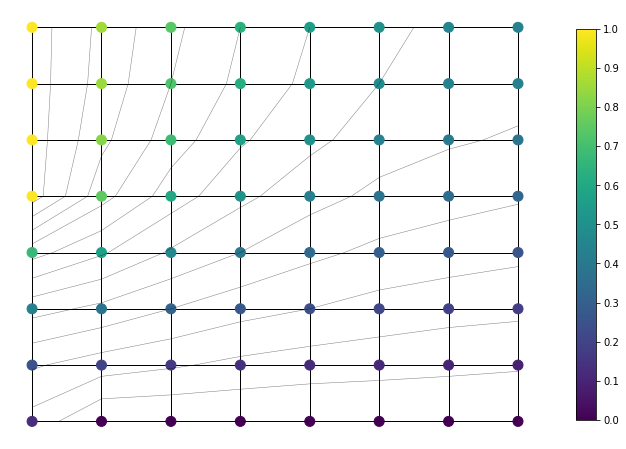

In [6]:
# Make a list of the potentials, in the new order (for coloring the nodes)
potentials_ordered = [potentials[i-1] for i in b]

# Make the node labels the potentials.
labels = dict(zip(range(1, L*W + 1), potentials))
nx.relabel_nodes(G, labels)

cmap = 'viridis'

fig, ax = plt.subplots(figsize=(12,8))

# Draw
fig = nx.draw(G,node_size=100, pos=pos, with_labels=False, labels=labels, cmap=cmap, node_color = potentials_ordered, ax=ax)


# Contours
data = np.reshape(potentials_ordered, (L, W)).T
ax.contour(data, levels=15, colors='black', alpha=0.5, linewidths=0.5)


# Colorbar
# Source: https://stackoverflow.com/questions/43805821/matplotlib-add-colorbar-to-non-mappable-object
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(0,1,11), shrink=0.9, ax=ax)

plt.show()

## Effective Conductance

The effective conductance of the circuit is the total amount of current entering through the electrified $\phi=1$ nodes. Since we have already calculated the potentials, we can use the formula given by the Schur Complement $f=Kx$ to determine the vector representing the net current out of each node.

By rewriting the equation as $\begin{pmatrix} A & B^T \\ B & C \end{pmatrix} \begin{pmatrix} v \\ \textbf{x} \end{pmatrix}= \begin{pmatrix}f  \\ 0 \end{pmatrix}$, we deduce $f=[A-B^TC^{-1}B]v$.

We only need the currents out of the $\phi=1$ nodes, so we take the sum of the first $W$ entries of $f$.

In [7]:
from math import ceil
def get_ec(L, W):
    print(L, W, end=' ')
    '''Calculates the effective conductance of a graph with length L and width W.'''
    
    # Paramter setup
    G = nx.grid_2d_graph(L, W)
    G_pos = G.nodes
    a = list(G.nodes)
    
    W1 = ceil(W/2)
    b = np.arange(1, W1+1).reshape(W1, 1) # left edge
    b1 = np.arange(W1+1, W1+L).reshape(L-1, 1) # bottom edge
    b2 = np.array([list(range((W-1)*i + L+1, (W-1)*(i+1) + L+1)) for i in range(1, L)])

    b = list(np.vstack((b, np.hstack((b1,b2)).reshape(L*W-W,1))).flat)
    
    
    for i in range(W-W1):
        b.insert(i, W1+L+i)
    d = dict(zip(a,b))
    G = nx.relabel_nodes(G,d)

    # Laplacian matrix
    K = nx.linalg.laplacianmatrix.laplacian_matrix(G, nodelist=list(range(1, L*W+1))).toarray()

    # constructing v, extracting B, C and solving for x
    v = np.array([1]*(W1) + [0]*(L-1))
    A = K[:W1+L-1, :W1+L-1]
    B = K[W1+L-1:, :W1+L-1]
    C = K[W1+L-1:, W1+L-1:]
    
    # Schur Complement to get f
    f = ((A - B.T @ np.linalg.inv(C) @ B) @ v).flatten()
    
    print('- done')

    return sum(f[:(ceil(W/2))])

get_ec(8, 5)

8 5 - done


1.3415209368486645

In [23]:
x = list(np.arange(0.4, 1.1, 0.1))
y = [get_ec(int(ratio*80),80)-0.05 for ratio in x] 

32 80 - done
40 80 - done
48 80 - done
56 80 - done
63 80 - done
72 80 - done
79 80 - done


In [24]:
y2 = [float(x) for x in "0.5673  0.6523  0.7206  0.7738  0.8143  0.8445  0.8666".split()]

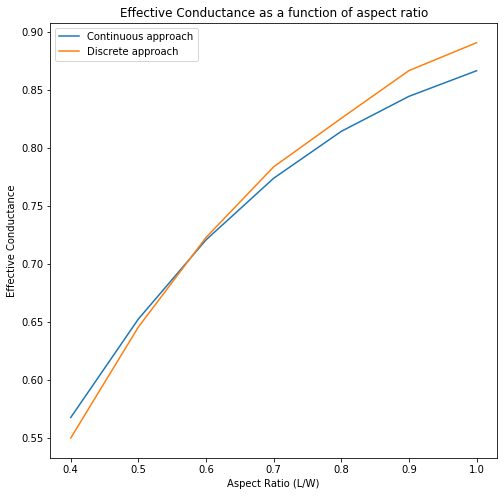

In [25]:
plt.figure(figsize=(8,8))
plt.title('Effective Conductance as a function of aspect ratio')
plt.xlabel('Aspect Ratio (L/W)')
plt.ylabel('Effective Conductance')
plt.plot(x, y2[:7], label='Continuous approach')
plt.plot(x, y[:7], label='Discrete approach')
# plt.plot(x, kai[:7], label='Continuous Approach (Kai)')
# plt.ylim([0, 1])
plt.legend();